In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [85]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [17]:
# Import datasets
empinfo_dri = pd.read_excel('Empinfo_DRI_FY16&17.xlsx')
apr_17 = pd.read_excel('APR_2017.xlsx')
empinfo_all = pd.read_excel('all_empinfo_short.xlsx')


In [18]:
# Clean Emplid
empinfo_dri['Emplid'] = empinfo_dri['Emplid'].astype(str)
empinfo_dri['Emplid']= empinfo_dri['Emplid'].str.strip()
empinfo_dri['Emplid'] = empinfo_dri['Emplid'].str.pad(6, fillchar = '0')

apr_17['Emplid'] = apr_17['Emplid'].astype(str)
apr_17['Emplid']= apr_17['Emplid'].str.strip()
apr_17['Emplid'] = apr_17['Emplid'].str.pad(6, fillchar = '0')

empinfo_all['Emplid'] = empinfo_all['Emplid'].astype(str)
empinfo_all['Emplid']= empinfo_all['Emplid'].str.strip()
empinfo_all['Emplid'] = empinfo_all['Emplid'].str.pad(6, fillchar = '0')

In [19]:
# Filter for Empinfo FY17
#empinfo_17 = empinfo_all[empinfo_all.FY == 2017]

# Merge Empinfo-dri and 2017 APR ratings
empinfo_dri = pd.merge(empinfo_dri, apr_17, how = 'left', on = 'Emplid')

# Merge 2017 APR and EMpinfo_all
empinfo_all = pd.merge(empinfo_all, apr_17, how = 'left', on = 'Emplid')

In [20]:
# Fill blank ratings with "No Rating"
empinfo_all['2015 Rating'] = empinfo_all['2015 Rating'].fillna('No Rating')
empinfo_all['2016 Rating'] = empinfo_all['2016 Rating'].fillna('No Rating')
empinfo_all['2017 Rating'] = empinfo_all['2017 Rating'].fillna('No Rating')

In [21]:
empinfo_all.loc[empinfo_all.FY == 2015].groupby(['2015 Rating']).size()

2015 Rating
E            1727
N              66
No Rating    1241
O             355
S             377
dtype: int64

In [24]:
empinfo_all.loc[empinfo_all.FY == 2015].groupby(['2016 Rating']).size()

2016 Rating
E            1711
No Rating    1306
O             370
S             379
dtype: int64

In [25]:
empinfo_all.loc[empinfo_all.FY == 2015].groupby(['2017 Rating']).size()

2017 Rating
E            1651
N               3
No Rating    1286
O             361
R              88
S             377
dtype: int64

In [32]:
# Encode ratings into 0 and 1
def rating_recode(rating):
    if rating in ['O', 'S']:
        return 1
    else:
        return 0

empinfo_dri['2017 Rating (num)'] = empinfo_dri['2017 Rating'].apply(rating_recode)
empinfo_dri['2016 Rating (num)'] = empinfo_dri['2016 Rating'].apply(rating_recode)
empinfo_dri['2015 Rating (num)'] = empinfo_dri['2015 Rating'].apply(rating_recode)

empinfo_all['2017 Rating (num)'] = empinfo_all['2017 Rating'].apply(rating_recode)
empinfo_all['2016 Rating (num)'] = empinfo_all['2016 Rating'].apply(rating_recode)
empinfo_all['2015 Rating (num)'] = empinfo_all['2015 Rating'].apply(rating_recode)


In [104]:
# Create a flag for people with at least 1 'O' or 'S' during past 3 yrs
empinfo_dri['O/S past 3 yrs'] = np.where((empinfo_dri['2017 Rating (num)'] + empinfo_dri['2016 Rating (num)'] +
                                            empinfo_dri['2015 Rating (num)']) >=1, 1, 0)

empinfo_all['O/S past 3 yrs'] = np.where((empinfo_all['2017 Rating (num)'] + empinfo_all['2016 Rating (num)'] +
                                            empinfo_all['2015 Rating (num)']) >=1, 1, 0)

empinfo_dri['Number of O/S past 3 yrs'] = empinfo_dri[['2017 Rating (num)','2016 Rating (num)','2015 Rating (num)']].sum(axis = 1)

empinfo_all['Number of O/S past 3 yrs'] = empinfo_all[['2017 Rating (num)','2016 Rating (num)','2015 Rating (num)']].sum(axis = 1)


In [106]:
# Filter for FY15 to FY17
empinfo_15to17 = empinfo_all.loc[empinfo_all.FY.isin(np.arange(2015, 2018))]

In [107]:
empinfo_15to17.FY.value_counts()

2017    3837
2015    3766
2016    3760
Name: FY, dtype: int64

In [108]:
# Keep distinct people across 3 yrs (pooling distinct people across 3 yrs)
empinfo_15to17_dist_staff = empinfo_15to17.loc[empinfo_15to17['Grade'].isin(['A04', 'A05', 'A06', 'A07', 'A08',
                          'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B01', 'B02', 'B03'])]
empinfo_15to17_dist_staff = empinfo_15to17_dist_staff.drop_duplicates(['Emplid', '2015 Rating', '2016 Rating', '2017 Rating'])

In [109]:
empinfo_15to17_dist_staff.FY.value_counts()

2015    2588
2017     207
2016     188
Name: FY, dtype: int64

In [186]:
table1 = empinfo_15to17_dist_staff.pivot_table(index = 'O/S past 3 yrs', columns = 'Gender', 
                                               aggfunc = 'count', 
                            values = 'Emplid', margins = True)
#table1 = table1.reset_index()
table1

Gender,F,M,All
O/S past 3 yrs,,,
0,611.0,695.0,1306.0
1,760.0,917.0,1677.0
All,1371.0,1612.0,2983.0


In [190]:
table1_for_plot = table1.drop(['All'])
table1_for_plot = table1_for_plot.reset_index()
table1_for_plot

Gender,O/S past 3 yrs,F,M,All
0,0,611.0,695.0,1306.0
1,1,760.0,917.0,1677.0


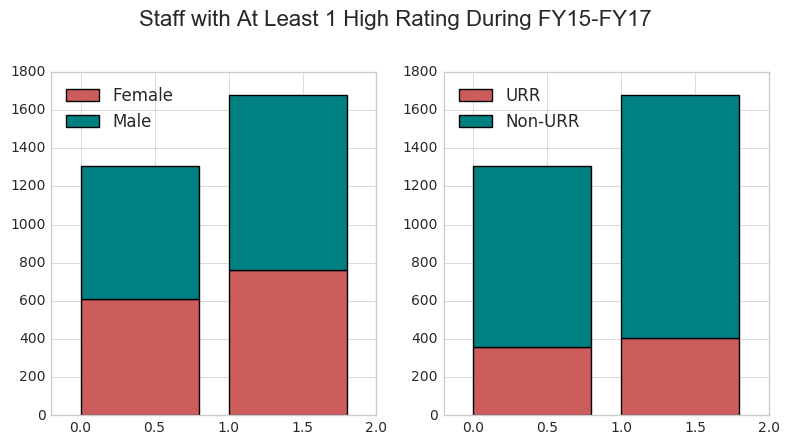

In [315]:
fig, ax = plt.subplots()

plt.subplot(1,2,1)
plt.bar(table1_for_plot['O/S past 3 yrs'], table1_for_plot['F'], color = 'indianred', label = 'Female')
plt.bar(table1_for_plot['O/S past 3 yrs'], table1_for_plot['M'],bottom = table1_for_plot['F'], color = 'teal', label = 'Male')
plt.xlim(-0.2, 2)
plt.legend(loc = 'upper left')
ax.set_xticks([0, 1])

plt.subplot(1,2,2)
plt.bar(table2_for_plot['O/S past 3 yrs'], table2_for_plot['Y'], color = 'indianred', label = 'URR')
plt.bar(table2_for_plot['O/S past 3 yrs'], table2_for_plot['N'], bottom = table2_for_plot['Y'], color = 'teal', label = 'Non-URR')
plt.xlim(-0.2, 2)
plt.legend(loc = 'upper left')
ax.set_xticks([0, 1])

plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17', y = 1.1, fontsize = 16)
fig.set_size_inches(w=8,h=4)
fig.tight_layout()
plt.show()


In [96]:
# Share of staff with at least 1 O/S rating
table1_per = empinfo_15to17_dist_staff.groupby(['O/S past 3 yrs', 'Gender'])['Emplid'].count()
table1_per = table1_per .groupby(level = [0, 1]).apply(lambda x: x*100/len(empinfo_15to17_dist_staff))
table1_per  = table1_per .unstack('Gender')
table1_per  = table1_per .reset_index()
table1_per  = table1_per .round(1)
table1_per ['Total'] = table1_per .F + table1_per.M
table1_per 

Gender,O/S past 3 yrs,F,M,Total
0,0,20.5,23.3,43.8
1,1,25.5,30.7,56.2


In [240]:
table2 = empinfo_15to17_dist_staff.pivot_table(index = 'O/S past 3 yrs', columns = 'URR', 
                                               aggfunc = 'count', 
                            values = 'Emplid', margins = True)
#table2 = table2.reset_index()
table2

URR,N,Y,All
O/S past 3 yrs,,,
0,950.0,356.0,1306.0
1,1273.0,404.0,1677.0
All,2223.0,760.0,2983.0


In [241]:
table2_for_plot = table2.drop(['All'])
table2_for_plot = table2_for_plot.reset_index()
table2_for_plot

URR,O/S past 3 yrs,N,Y,All
0,0,950.0,356.0,1306.0
1,1,1273.0,404.0,1677.0


In [98]:
table2_per = empinfo_15to17_dist_staff.groupby(['O/S past 3 yrs', 'URR'])['Emplid'].count()
table2_per = table2_per .groupby(level = [0, 1]).apply(lambda x: x*100/len(empinfo_15to17_dist_staff))
table2_per  = table2_per .unstack('URR')
table2_per  = table2_per .reset_index()
table2_per  = table2_per .round(1)
table2_per ['Total'] = table2_per .N + table2_per.Y
table2_per 

URR,O/S past 3 yrs,N,Y,Total
0,0,31.8,11.9,43.7
1,1,42.7,13.5,56.2


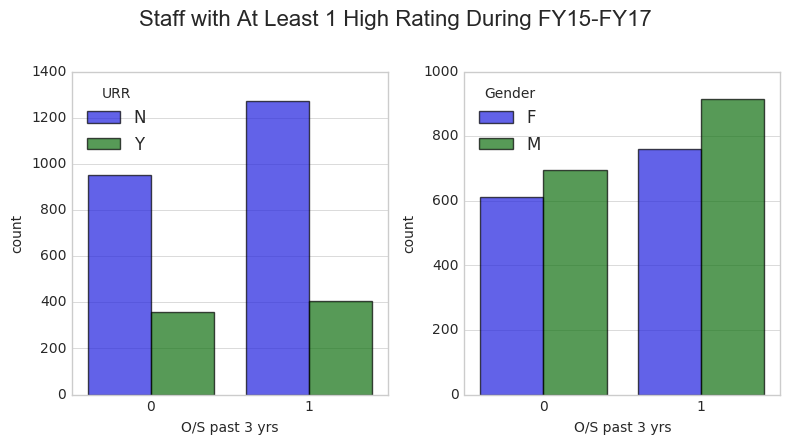

In [179]:
fig = plt.figure()

plt.subplot(1,2,1)
sns.countplot(x = 'O/S past 3 yrs', hue = 'URR', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.subplot(1,2,2)
sns.countplot(x = 'O/S past 3 yrs', hue = 'Gender', data = empinfo_15to17_dist_staff, alpha = 0.7)

plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17', y = 1.1, fontsize = 16)
fig.set_size_inches(w=8,h=4)
fig.tight_layout()
plt.show()

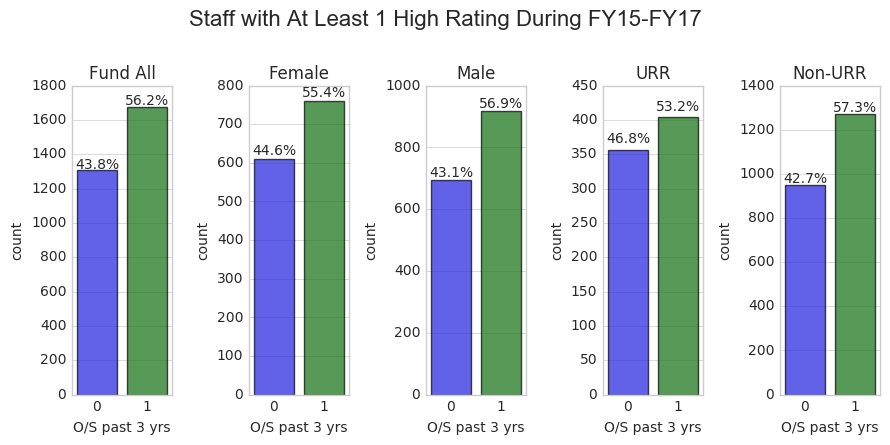

In [534]:
# New code - bar plot - at least 1 high rating FY15 to 17
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(9, 4), sharey=False)

sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff, alpha = 0.7, ax = ax1)
ax1.set_title('Fund All')

sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'F'], 
              alpha = 0.7,ax = ax2)
ax2.set_title('Female')

sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'M'], 
              alpha = 0.7, ax = ax3)
ax3.set_title('Male')

sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'Y'], 
              alpha = 0.7, ax = ax4)
ax4.set_title('URR')

sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'N'], 
              alpha = 0.7, ax = ax5)
ax5.set_title('Non-URR')

plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17', y = 1.1, fontsize = 16)

total = len(empinfo_15to17_dist_staff)
total_f = len(empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'F'])
total_m = len(empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'M'])
total_urr = len(empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'Y'])
total_nurr = len(empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'N'])

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/total*100),
            ha="center") 
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/total_f*100),
            ha="center")
for p in ax3.patches:
    height = p.get_height()
    ax3.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/total_m*100),
            ha="center") 
for p in ax4.patches:
    height = p.get_height()
    ax4.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/total_urr*100),
            ha="center")
for p in ax5.patches:
    height = p.get_height()
    ax5.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/total_nurr*100),
            ha="center") 
f.tight_layout()
plt.show()

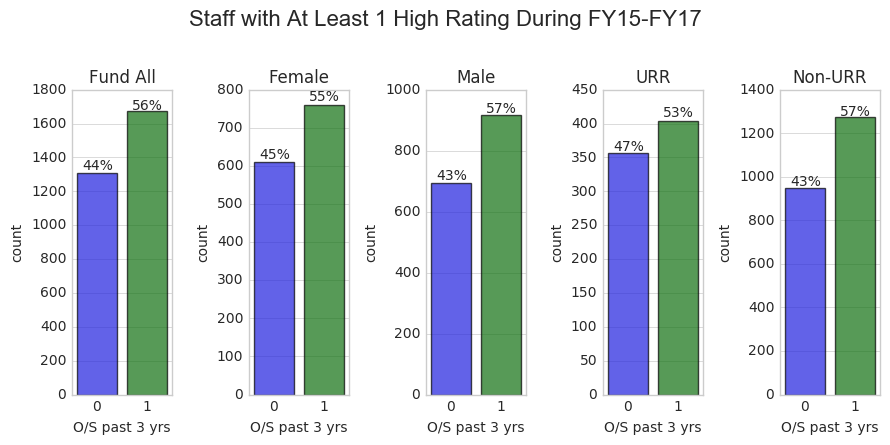

In [393]:
# Old code
fig = plt.figure()

#plt.subplot(1,2,1)
#sns.countplot(x = 'O/S past 3 yrs', hue = 'URR', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.subplot(1,5,1)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.title('Fund All')
plt.annotate('44%', xy = (0, 1300), xytext = (-0.3, 1330))
plt.annotate('56%', xy = (1, 1677), xytext = (0.7, 1680))

plt.subplot(1,5,2)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'F'], alpha = 0.7)
plt.title('Female')
plt.annotate('45%', xy = (0, 611), xytext = (-0.3, 620))
plt.annotate('55%', xy = (1, 760), xytext = (0.7, 770))

plt.subplot(1,5,3)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'M'], alpha = 0.7)
plt.title('Male')
plt.annotate('43%', xy = (0, 695), xytext = (-0.3, 705))
plt.annotate('57%', xy = (1, 917), xytext = (0.7, 925))


plt.subplot(1,5,4)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'Y'], alpha = 0.7)
plt.title('URR')
plt.annotate('47%', xy = (0, 356), xytext = (-0.3, 360))
plt.annotate('53%', xy = (1, 404), xytext = (0.7, 410))

plt.subplot(1,5,5)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'N'], alpha = 0.7)
plt.title('Non-URR')
plt.annotate('43%', xy = (0, 950), xytext = (-0.3, 960))
plt.annotate('57%', xy = (1, 1273), xytext = (0.7, 1280))

plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17', y = 1.1, fontsize = 16)
fig.set_size_inches(w=9,h=4)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('Plots/Staff with At Least 1 High Rating past 3 yrs.png')
plt.show()


In [113]:
empinfo_15to17_dist_staff['Number of O/S past 3 yrs'].value_counts()

0    1306
1    1165
2     454
3      58
Name: Number of O/S past 3 yrs, dtype: int64

In [216]:
# Set up data for stacked plot for number of high ratings - stacked by gender
stacked_bar_tbl = empinfo_15to17_dist_staff.pivot_table(index = 'Number of O/S past 3 yrs', columns = 'Gender', 
                                               aggfunc = 'count', 
                            values = 'Emplid')

#stacked_bar_tbl = table1.drop(['All'])
stacked_bar_tbl = stacked_bar_tbl.reset_index()
stacked_bar_tbl


Gender,Number of O/S past 3 yrs,F,M
0,0,611,695
1,1,533,632
2,2,194,260
3,3,33,25


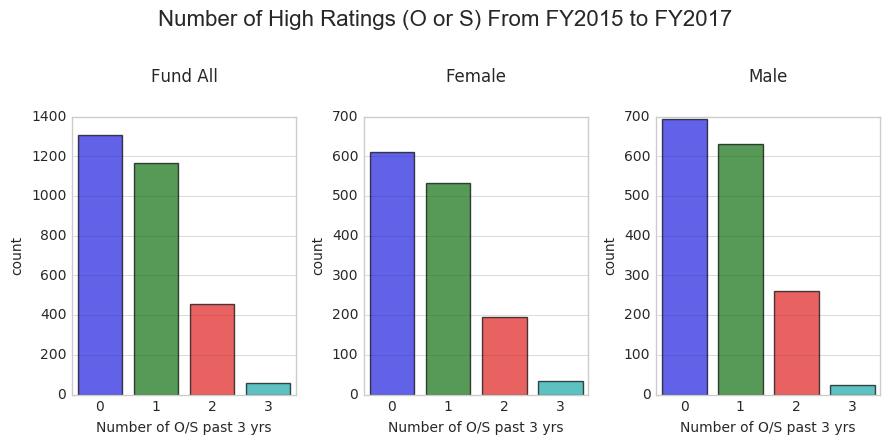

In [309]:
fig = plt.figure()

plt.subplot(1, 3, 1)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.title('Fund All', y = 1.1)

plt.subplot(1, 3, 2)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'F']
              , alpha = 0.7)
plt.title('Female', y = 1.1)

plt.subplot(1, 3, 3)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Gender == 'M']
              , alpha = 0.7)
plt.title('Male', y = 1.1)

plt.suptitle('Number of High Ratings (O or S) From FY2015 to FY2017', y = 1.1, fontsize = 16)
fig.set_size_inches(w = 9, h = 4)
fig.tight_layout()
plt.savefig('Plots/Staff with At Least 1 High Rating past 3 yrs.png')
plt.show()

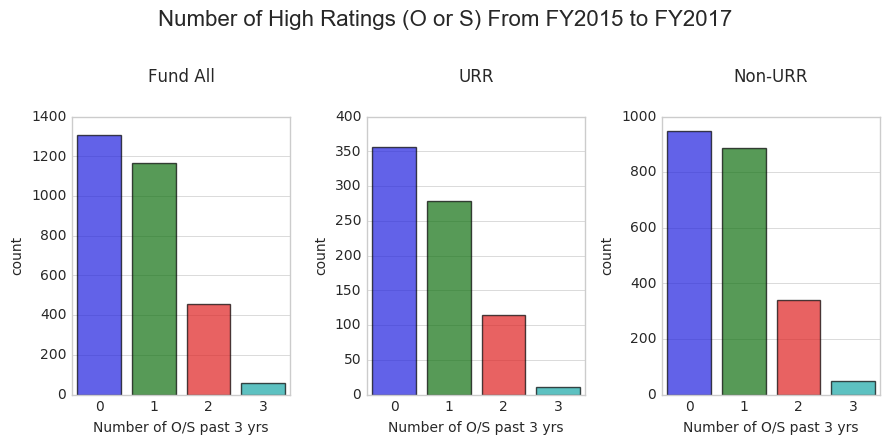

In [308]:
fig = plt.figure()

plt.subplot(1, 3, 1)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.title('Fund All', y = 1.1)

plt.subplot(1, 3, 2)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'Y']
              , alpha = 0.7)
plt.title('URR', y = 1.1)

plt.subplot(1, 3, 3)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.URR == 'N']
              , alpha = 0.7)
plt.title('Non-URR', y = 1.1)

plt.suptitle('Number of High Ratings (O or S) From FY2015 to FY2017', y = 1.1, fontsize = 16)
fig.set_size_inches(w = 9, h = 4)
fig.tight_layout()
plt.show()

In [369]:
empinfo_15to17_dist_staff['Diversity Region'].value_counts()

Europe (excl. Transition Countries)    710
U.S. & Canada                          678
East Asia (ASEAN+)                     383
Other Western Hemisphere               376
Transition Countries                   237
Africa (Sub-Saharan)                   237
Asia (excl. East Asia)                 214
Middle East & North Africa+ (MENA+)    140
Name: Diversity Region, dtype: int64

In [ ]:
# MEdian DRI Rating for each Region
empinfo

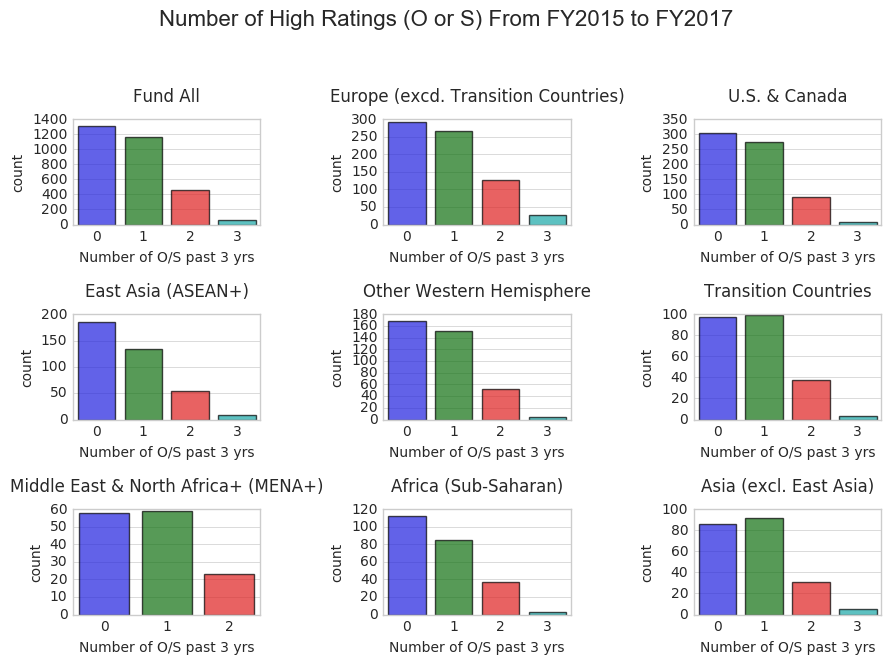

In [376]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.title('Fund All', y = 1.1)

plt.subplot(3, 3, 2)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Europe (excl. Transition Countries)'], alpha = 0.7)
plt.title('Europe (excd. Transition Countries)', y = 1.1)


plt.subplot(3, 3, 3)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'U.S. & Canada']
              , alpha = 0.7)
plt.title('U.S. & Canada', y = 1.1)

plt.subplot(3, 3, 4)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'East Asia (ASEAN+)']
              , alpha = 0.7)
plt.title('East Asia (ASEAN+)', y = 1.1)

plt.subplot(3, 3, 5)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Other Western Hemisphere']
              , alpha = 0.7)
plt.title('Other Western Hemisphere', y = 1.1)

plt.subplot(3, 3, 6)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Transition Countries']
              , alpha = 0.7)
plt.title('Transition Countries', y = 1.1)

plt.subplot(3, 3, 7)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Middle East & North Africa+ (MENA+)']
              , alpha = 0.7)
plt.title('Middle East & North Africa+ (MENA+)', y = 1.1)

plt.subplot(3, 3, 8)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Africa (Sub-Saharan)']
              , alpha = 0.7)
plt.title('Africa (Sub-Saharan)', y = 1.1)

plt.subplot(3, 3, 9)
sns.countplot(x = 'Number of O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Asia (excl. East Asia)']
              , alpha = 0.7)
plt.title('Asia (excl. East Asia)', y = 1.1)

plt.suptitle('Number of High Ratings (O or S) From FY2015 to FY2017', y = 1.1, fontsize = 16)
fig.set_size_inches(w = 9, h = 6)
fig.tight_layout()
plt.show()

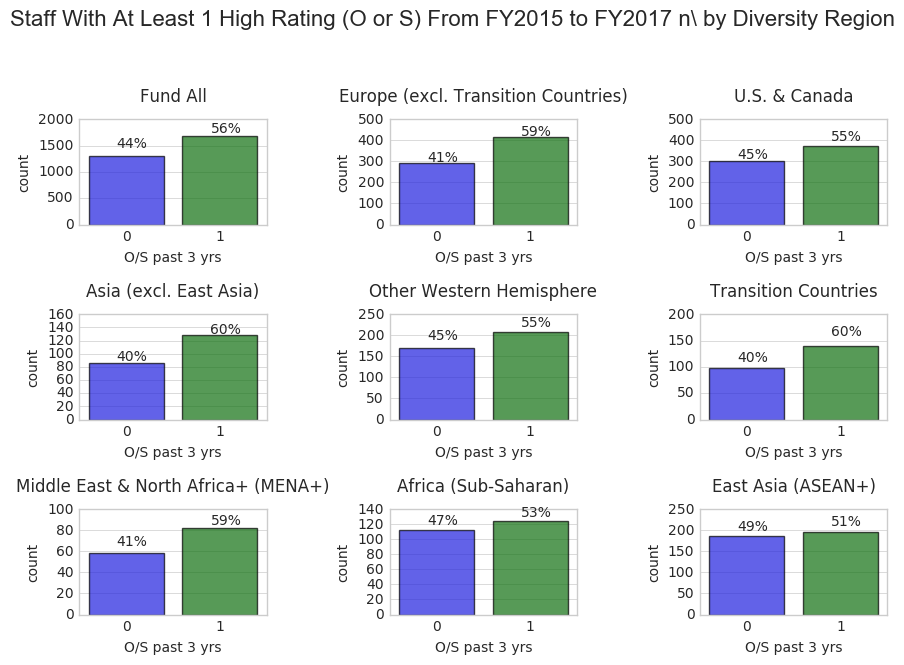

In [500]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff, alpha = 0.7)
plt.title('Fund All', y = 1.1)
plt.ylim(0,2000)
plt.annotate('44%', xy = (0, 100), xytext = (-0.1, 1450))
plt.annotate('56%', xy = (1, 190), xytext = (0.9, 1750))


plt.subplot(3, 3, 2)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Europe (excl. Transition Countries)'], alpha = 0.7)
plt.title('Europe (excl. Transition Countries)', y = 1.1)
plt.ylim(0,500)
plt.annotate('41%', xy = (0, 100), xytext = (-0.1, 300))
plt.annotate('59%', xy = (1, 190), xytext = (0.9, 420))


plt.subplot(3, 3, 3)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'U.S. & Canada']
              , alpha = 0.7)
plt.title('U.S. & Canada', y = 1.1)
plt.ylim(0,500)
plt.annotate('45%', xy = (0, 100), xytext = (-0.1, 310))
plt.annotate('55%', xy = (1, 190), xytext = (0.9, 400))


plt.subplot(3, 3, 9)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'East Asia (ASEAN+)']
              , alpha = 0.7)
plt.title('East Asia (ASEAN+)', y = 1.1)
plt.ylim(0,250)
plt.annotate('49%', xy = (0, 100), xytext = (-0.1, 200))
plt.annotate('51%', xy = (1, 190), xytext = (0.9, 210))



plt.subplot(3, 3, 5)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Other Western Hemisphere']
              , alpha = 0.7)
plt.title('Other Western Hemisphere', y = 1.1)
#plt.ylim(0,500)
plt.annotate('45%', xy = (0, 100), xytext = (-0.1, 190))
plt.annotate('55%', xy = (1, 190), xytext = (0.9, 220))


plt.subplot(3, 3, 6)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Transition Countries']
              , alpha = 0.7)
plt.title('Transition Countries', y = 1.1)
plt.ylim(0,200)
plt.annotate('40%', xy = (0, 100), xytext = (-0.1, 110))
plt.annotate('60%', xy = (1, 190), xytext = (0.9, 160))


plt.subplot(3, 3, 7)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Middle East & North Africa+ (MENA+)']
              , alpha = 0.7)
plt.title('Middle East & North Africa+ (MENA+)', y = 1.1)
plt.ylim(0,100)
plt.annotate('41%', xy = (0, 60), xytext = (-0.1, 65))
plt.annotate('59%', xy = (1, 80), xytext = (0.9, 85))


plt.subplot(3, 3, 8)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Africa (Sub-Saharan)']
              , alpha = 0.7)
plt.title('Africa (Sub-Saharan)', y = 1.1)
#plt.ylim(0,500)
plt.annotate('47%', xy = (0, 100), xytext = (-0.1, 120))
plt.annotate('53%', xy = (1, 120), xytext = (0.9, 130))


plt.subplot(3, 3, 4)
sns.countplot(x = 'O/S past 3 yrs', data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff['Diversity Region'] == 
                            'Asia (excl. East Asia)']
              , alpha = 0.7)
plt.title('Asia (excl. East Asia)', y = 1.1)
plt.ylim(0,160)
plt.annotate('40%', xy = (0, 100), xytext = (-0.1, 90))
plt.annotate('60%', xy = (1, 120), xytext = (0.9, 130))

plt.suptitle('Staff With At Least 1 High Rating (O or S) From FY2015 to FY2017 n\ by Diversity Region', y = 1.1, fontsize = 16)
fig.set_size_inches(w = 9, h = 6)
fig.tight_layout()
plt.show()

In [489]:
region_table = empinfo_15to17_dist_staff.groupby(['Diversity Region', 'O/S past 3 yrs']).size()
region_table = region_table.groupby(level = 0).apply(lambda x: x*100/x.sum())
region_table

Diversity Region                     O/S past 3 yrs
Africa (Sub-Saharan)                 0                 47.257384
                                     1                 52.742616
Asia (excl. East Asia)               0                 40.186916
                                     1                 59.813084
East Asia (ASEAN+)                   0                 48.563969
                                     1                 51.436031
Europe (excl. Transition Countries)  0                 41.126761
                                     1                 58.873239
Middle East & North Africa+ (MENA+)  0                 41.428571
                                     1                 58.571429
Other Western Hemisphere             0                 44.946809
                                     1                 55.053191
Transition Countries                 0                 40.928270
                                     1                 59.071730
U.S. & Canada                        0

In [415]:
# Def function to map grade and position level

def grade_group(grade, position):
    if position == 'B01-B03':
        return 'B01-B03'
    if position == 'DDC level':
        return 'DDC level'
    if (grade in ['A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']) & (position != 'DDC level'):
        return 'A9 to Non-DDC'
    else: 
        return 'A1-A8'
 


In [423]:
# Create new column called 'Grade_Group'
empinfo_15to17_dist_staff['Grade_Group'] = empinfo_15to17_dist_staff.apply(lambda x: grade_group(x['Grade'], 
                                        x['Position Level']), axis = 1)
empinfo_15to17_dist_staff['Grade_Group'] = pd.Categorical(empinfo_15to17_dist_staff['Grade_Group'], ['B01-B03', 'DDC level',
                                        'A9 to Non-DDC', 'A1-A8'], ordered = True)

In [470]:
empinfo_15to17_dist_staff['Incumbent Type'].value_counts()

Specialized Career Stream    1438
Fungible Macroeconomist      1263
Specialist                    281
Select Value for MCP            1
Name: Incumbent Type, dtype: int64

In [477]:
# Add column for career stream
empinfo_15to17_dist_staff['Career_Stream'] = np.where(empinfo_15to17_dist_staff['Incumbent Type'] == 
                                                       'Specialized Career Stream',
                                                       'Specialized Career Stream', 'Economist')

In [457]:
factor_table = empinfo_15to17_dist_staff.groupby(['Grade_Group', 'O/S past 3 yrs']).size()
factor_table = factor_table.groupby(level = 0).apply(lambda x: x*100/x.sum())
#factor_table = factor_table.reset_index()
#factor_table.columns = ['Grade Group', 'O/S past 3 yrs', 'Count']
factor_table

Grade_Group    O/S past 3 yrs
B01-B03        0                 35.125448
               1                 64.874552
DDC level      0                 30.069930
               1                 69.930070
A9 to Non-DDC  0                 46.743295
               1                 53.256705
A1-A8          0                 45.346870
               1                 54.653130
dtype: float64

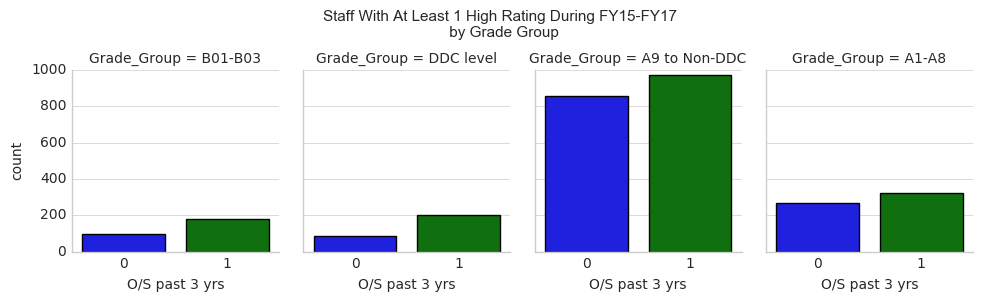

In [448]:
sns.factorplot('O/S past 3 yrs', col = 'Grade_Group', data = empinfo_15to17_dist_staff, kind = 'count', size = 2.7,
              aspect = 0.9)
plt.suptitle('Staff With At Least 1 High Rating During FY15-FY17 \n by Grade Group', y = 1.1, fontsize = 11)

plt.show()

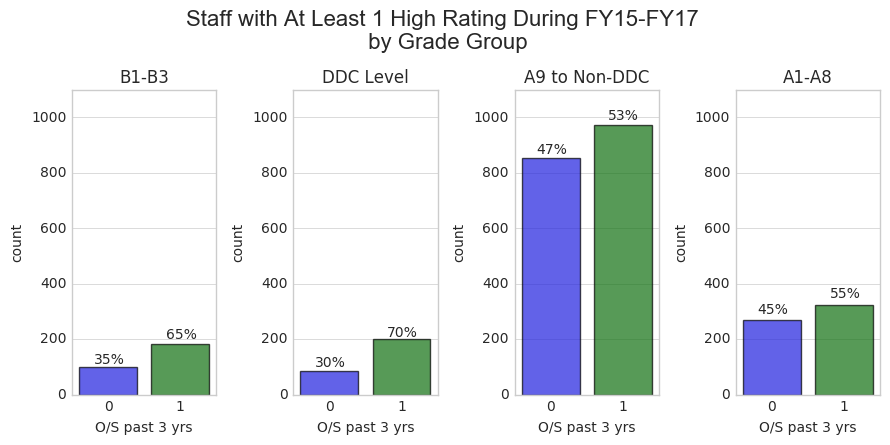

In [466]:
fig = plt.figure()

plt.subplot(1,4,1)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Grade_Group == 
                                                                          'B01-B03'], alpha = 0.7)
plt.title('B1-B3')
plt.annotate('35%', xy = (0, 100), xytext = (-0.2, 110))
plt.annotate('65%', xy = (1, 190), xytext = (0.8, 200))
plt.ylim(0, 1100)

plt.subplot(1,4,2)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Grade_Group ==
                                                                          'DDC level'], alpha = 0.7)
plt.title('DDC Level')
plt.annotate('30%', xy = (0, 90), xytext = (-0.2, 100))
plt.annotate('70%', xy = (1, 200), xytext = (0.8, 210))
plt.ylim(0, 1100)

plt.subplot(1,4, 3)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Grade_Group ==
                                                                          'A9 to Non-DDC'], alpha = 0.7)
plt.title('A9 to Non-DDC')
plt.ylim(0, 1100)
plt.annotate('47%', xy = (0, 820), xytext = (-0.2, 870))
plt.annotate('53%', xy = (1, 950), xytext = (0.8, 990))

plt.subplot(1,4,4)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Grade_Group ==
                                                                          'A1-A8'], alpha = 0.7)
plt.title('A1-A8')
plt.annotate('45%', xy = (0, 290), xytext = (-0.2, 290))
plt.annotate('55%', xy = (1, 350), xytext = (0.8, 350))
plt.ylim(0, 1100)

plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17 \n by Grade Group', y = 1.1, fontsize = 16)
fig.set_size_inches(w=9,h=4)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [479]:
carstream_table = empinfo_15to17_dist_staff.groupby(['Career_Stream', 'O/S past 3 yrs']).size()
carstream_table = carstream_table.groupby(level = 0).apply(lambda x: x*100/x.sum())
#factor_table = factor_table.reset_index()
#factor_table.columns = ['Grade Group', 'O/S past 3 yrs', 'Count']
carstream_table

Career_Stream              O/S past 3 yrs
Economist                  0                 41.488673
                           1                 58.511327
Specialized Career Stream  0                 46.244784
                           1                 53.755216
dtype: float64

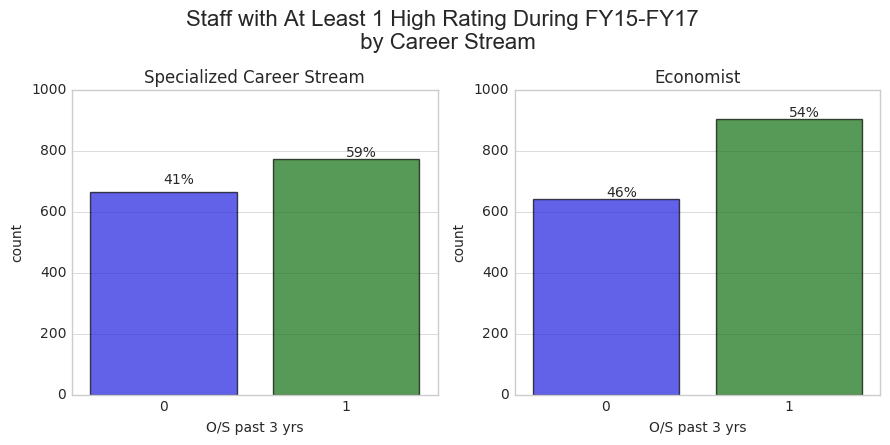

In [482]:
fig = plt.figure()

plt.subplot(1,2,1)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Career_Stream == 
                                                                          'Specialized Career Stream'], alpha = 0.7)
plt.title('Specialized Career Stream')
plt.annotate('41%', xy = (0, 650), xytext = (0, 690))
plt.annotate('59%', xy = (1, 770), xytext = (1, 780))
plt.ylim(0, 1000)

plt.subplot(1,2,2)
sns.countplot(x = 'O/S past 3 yrs',  data = empinfo_15to17_dist_staff.loc[empinfo_15to17_dist_staff.Career_Stream ==
                                                                          'Economist'], alpha = 0.7)
plt.title('Economist')
plt.annotate('46%', xy = (0, 620), xytext = (0, 650))
plt.annotate('54%', xy = (1, 900), xytext = (1, 910))
#plt.ylim(0, 1100)



plt.suptitle('Staff with At Least 1 High Rating During FY15-FY17 \n by Career Stream', y = 1.1, fontsize = 16)
fig.set_size_inches(w=9,h=4)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [299]:
# Set up data for stacked plot for number of high ratings - stacked by urr
stacked_bar_tbl2 = empinfo_15to17_dist_staff.pivot_table(index = 'Number of O/S past 3 yrs', columns = 'URR', 
                                               aggfunc = 'count', 
                            values = 'Emplid')

#stacked_bar_tbl = table1.drop(['All'])
stacked_bar_tbl2 = stacked_bar_tbl2.reset_index()
stacked_bar_tbl2

URR,Number of O/S past 3 yrs,N,Y
0,0,950,356
1,1,887,278
2,2,339,115
3,3,47,11


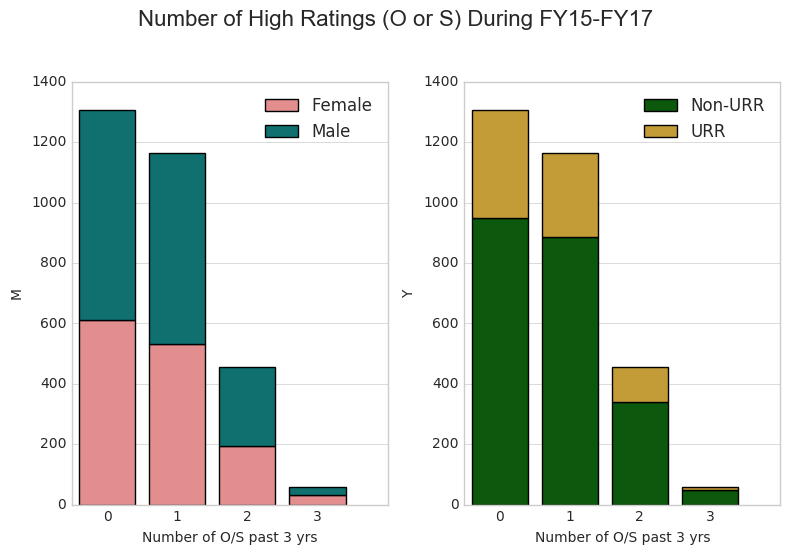

In [274]:
fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
sns.barplot(stacked_bar_tbl['Number of O/S past 3 yrs'], stacked_bar_tbl['F'], color = 'lightcoral', label = 'Female')
sns.barplot(stacked_bar_tbl['Number of O/S past 3 yrs'], stacked_bar_tbl['M'], bottom = stacked_bar_tbl['F'], color = 'teal', label = 'Male')

plt.legend(loc = 'upper right')
ax.set_xticks([0, 1, 2, 3])
plt.xlim(-0.5, 4)


plt.subplot(1,2, 2)
sns.barplot(stacked_bar_tbl2['Number of O/S past 3 yrs'], stacked_bar_tbl2['N'], color = 'darkgreen', label = 'Non-URR')
sns.barplot(stacked_bar_tbl2['Number of O/S past 3 yrs'], stacked_bar_tbl2['Y'], bottom = stacked_bar_tbl2['N'], color = 'goldenrod', label = 'URR')

plt.legend(loc = 'upper right')
ax.set_xticks([0, 1, 2, 3])
plt.xlim(-0.5, 4)
plt.suptitle('Number of High Ratings (O or S) During FY15-FY17', y = 1.1, fontsize = 16)

fig.set_size_inches(w=8,h=5)
fig.tight_layout()
plt.show()

In [ ]:
empinfo_15to17_dist_staff['A']

In [131]:
empinfo_dri.head()

,ID,FY,Rated,Unrated,Emplid,Name,Gender,Nationality,Dept ID,Job Title,...,Overtime hours,Annual Leave Used (Days),Annual Leave Lost (Days),Mean Rating (log),2017 Rating,2017 Rating (num),2016 Rating (num),2015 Rating (num),O/S past 3 yrs,Number of O/S past 3 yrs
0,01568E,2016,0.775510,0.224490,01568E,"Aitken,Brian J.",M,U.S.,APD,Advisor (Area),...,9.99999,23.0,0.0,0.212561,E,0,0,0,0,0
1,01568E,2017,0.269841,0.730159,01568E,"Aitken,Brian J.",M,U.S.,APD,Division Chief (Area),...,160.01994,40.0,0.0,0.257829,E,0,0,0,0,0
2,01608S,2016,0.723810,0.276190,01608S,"Al-Atrash,Hassan M.",M,Syr Arb Rep,SEC,Division Chief,...,0.00000,22.5,0.0,0.201866,E,0,1,0,1,1
3,01608S,2017,0.633929,0.366071,01608S,"Al-Atrash,Hassan M.",M,Syr Arb Rep,SEC,Assistant Director,...,0.00000,24.0,0.0,0.131769,E,0,1,0,1,1
4,018569,2016,0.584416,0.415584,018569,"Almekinders,Gerard J.",M,Netherlands,APD,Deputy Division Chief (Area),...,432.98994,22.5,0.0,0.635989,S,1,0,1,1,2


In [137]:
table3 = empinfo_dri.pivot_table(index = "Median Rating", columns = 'O/S past 3 yrs', values = 'Emplid', aggfunc = 'count')
table3 = table3.reset_index()
table3 = table3.fillna(0)
table3.columns = ['Median Rating', 'No O/S past 3 yrs', 'At least 1 O/S past 3yrs']
table3['Total'] = table3['No O/S past 3 yrs'] + table3['At least 1 O/S past 3yrs']
table3

,Median Rating,No O/S past 3 yrs,At least 1 O/S past 3yrs,Total
0,1.0,189.0,513.0,702.0
1,1.5,10.0,23.0,33.0
2,2.0,136.0,250.0,386.0
3,2.5,0.0,1.0,1.0
4,3.0,2.0,2.0,4.0


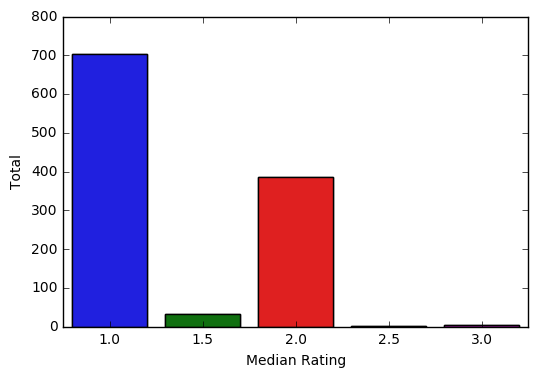

In [140]:
sns.barplot(x="Median Rating", y="Total", data=table3)
plt.show()

In [637]:
# Set up data for stacked plot for number of high ratings - 
empinfo_dri17 = empinfo_dri.loc[empinfo_dri.FY == 2017]
stacked_bar_dri = empinfo_dri17.pivot_table(index = 'Median Rating', columns = 'O/S past 3 yrs', 
                                               aggfunc = 'count', 
                            values = 'Emplid')

#stacked_bar_tbl = table1.drop(['All'])
stacked_bar_dri = stacked_bar_dri.reset_index()
stacked_bar_dri.columns = ['Median DRI Rating', 'No High APR Rating', 'At Least 1 High APR Rating']
stacked_bar_dri

,Median DRI Rating,No High APR Rating,At Least 1 High APR Rating
0,1.0,104.0,287.0
1,1.5,7.0,12.0
2,2.0,66.0,128.0
3,2.5,NaN,1.0
4,3.0,1.0,2.0


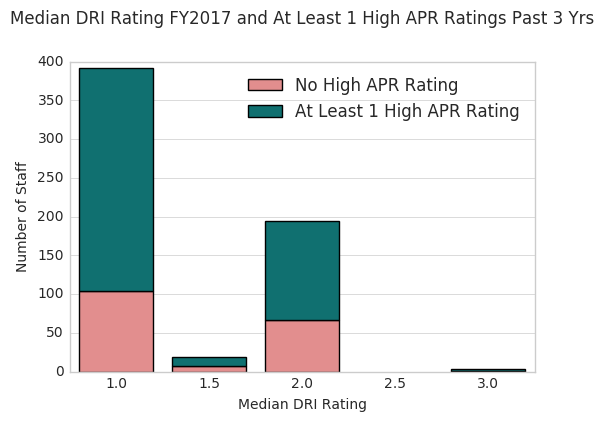

In [641]:
fig, ax = plt.subplots()
sns.barplot(stacked_bar_dri['Median DRI Rating'], stacked_bar_dri['No High APR Rating'], color = 'lightcoral', label = 'No High APR Rating')
sns.barplot(stacked_bar_dri['Median DRI Rating'], stacked_bar_dri['At Least 1 High APR Rating'], bottom = stacked_bar_dri['No High APR Rating'], color = 'teal', label = 'At Least 1 High APR Rating')

plt.legend(loc = 'upper right')
plt.title('Median DRI Rating FY2017 and At Least 1 High APR Ratings Past 3 Yrs', y = 1.1)
ax.set_ylabel('Number of Staff')
plt.show()

In [590]:
# Stacked bar DRI Version 2
# Set up data for stacked plot for number of high ratings - 
empinfo_dri17 = empinfo_dri.loc[empinfo_dri.FY == 2017]
stacked_bar_dri2 = empinfo_dri17.pivot_table(columns = 'Median Rating',  index = 'Number of O/S past 3 yrs', 
                                               aggfunc = 'count', values = 'Emplid')
stacked_bar_dri2 = stacked_bar_dri2.fillna(0)
stacked_bar_dri2 = stacked_bar_dri2.reset_index()

stacked_bar_dri2.columns = ['Number of High APR Ratings past 3 yrs', '1.0', 'Median 1.5', 'Median 2', 'Median 2.5', 'Median 3']

stacked_bar_dri2['2'] = stacked_bar_dri2[['Median 1.5','Median 2']].sum(axis = 1)
stacked_bar_dri2['3'] = stacked_bar_dri2[['Median 2.5','Median 3']].sum(axis = 1)
stacked_bar_dri2= stacked_bar_dri2.drop(['Median 1.5', 'Median 2', 'Median 2.5', 'Median 3'], axis = 1)
stacked_bar_dri2 = stacked_bar_dri2.T
stacked_bar_dri2 = stacked_bar_dri2.reset_index()
stacked_bar_dri2.columns = ['Median DRI Rating', 'No High APR Rating', '1 High APR Rating', '2 High APR Rating', '3 High APR Rating']
stacked_bar_dri2 = stacked_bar_dri2.drop(0)
stacked_bar_dri2

,Median DRI Rating,No High APR Rating,1 High APR Rating,2 High APR Rating,3 High APR Rating
1,1.0,104.0,174.0,96.0,17.0
2,2,73.0,84.0,50.0,6.0
3,3,1.0,3.0,0.0,0.0


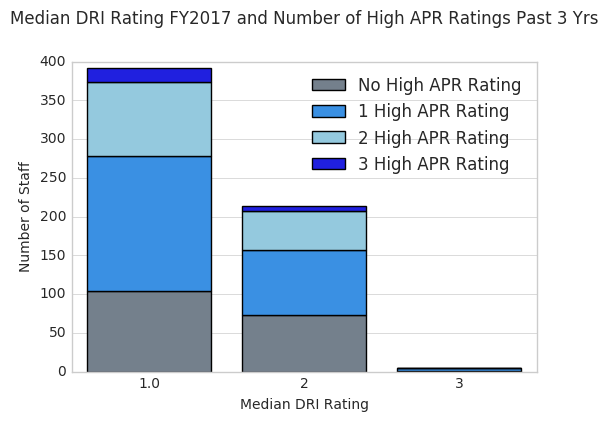

In [597]:
fig, ax = plt.subplots()
sns.barplot(stacked_bar_dri2['Median DRI Rating'], stacked_bar_dri2['No High APR Rating'], color = 'slategray', label = 'No High APR Rating')
sns.barplot(stacked_bar_dri2['Median DRI Rating'], stacked_bar_dri2['1 High APR Rating'], bottom = stacked_bar_dri2['No High APR Rating'], color = 'dodgerblue', label = '1 High APR Rating')
sns.barplot(stacked_bar_dri2['Median DRI Rating'], stacked_bar_dri2['2 High APR Rating'], bottom = stacked_bar_dri2['1 High APR Rating'] + stacked_bar_dri2['No High APR Rating'], color = 'skyblue', label = '2 High APR Rating')
sns.barplot(stacked_bar_dri2['Median DRI Rating'], stacked_bar_dri2['3 High APR Rating'], bottom = stacked_bar_dri2['2 High APR Rating'] +stacked_bar_dri2['1 High APR Rating'] + stacked_bar_dri2['No High APR Rating'], color = 'blue', label = '3 High APR Rating')
plt.legend(loc = 'upper right')
plt.title('Median DRI Rating FY2017 and Number of High APR Ratings Past 3 Yrs', y = 1.1)
ax.set_ylabel('Number of Staff')
plt.show()

In [407]:
# Matrix with numbers
matrix_number = empinfo_dri17.pivot_table(columns  = 'Median Rating', index = 'Number of O/S past 3 yrs', 
                                               aggfunc = 'count', 
                            values = 'Emplid')

#stacked_bar_tbl = table1.drop(['All'])
#matrix_number = matrix_number.reset_index()
#matrix_number.columns = ['Median DRI Rating', 'No High APR Rating', 'High APR Rating']
matrix_number = matrix_number.fillna(0)
matrix_number

Median Rating,1.0,1.5,2.0,2.5,3.0
Number of O/S past 3 yrs,,,,,
0,104.0,7.0,66.0,0.0,1.0
1,174.0,4.0,80.0,1.0,2.0
2,96.0,6.0,44.0,0.0,0.0
3,17.0,2.0,4.0,0.0,0.0


In [408]:
# Matrix with Median DRI and Number of High APR Ratings
matrix =empinfo_dri17.groupby(['Number of O/S past 3 yrs','Median Rating'])['Emplid'].count()
matrix = matrix.fillna(0)                               
matrix = matrix.groupby(level = [0,1]).apply(lambda x: x*100/len(empinfo_dri17[empinfo_dri17['Median Rating'].notnull()]))
matrix = matrix.unstack('Median Rating')
matrix = matrix.reset_index()
matrix = matrix.round(1).fillna(0)
matrix 

Median Rating,Number of O/S past 3 yrs,1.0,1.5,2.0,2.5,3.0
0,0,17.1,1.2,10.9,0.0,0.2
1,1,28.6,0.7,13.2,0.2,0.3
2,2,15.8,1.0,7.2,0.0,0.0
3,3,2.8,0.3,0.7,0.0,0.0


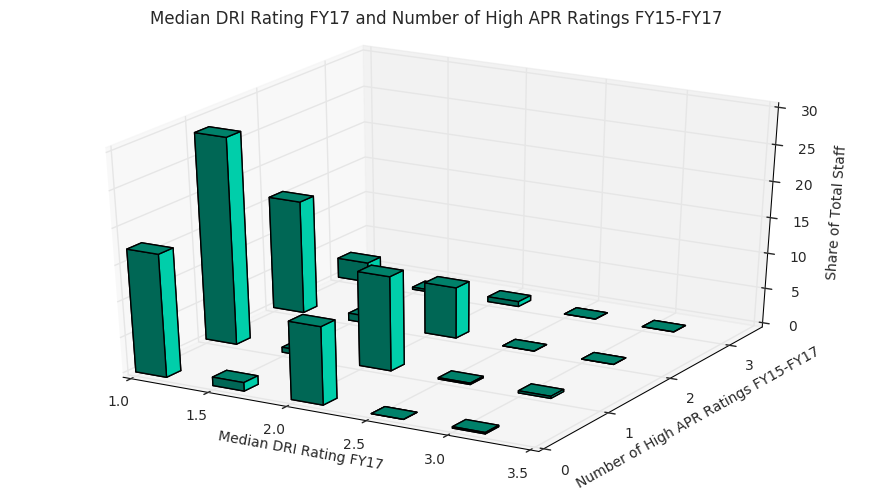

In [502]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
x = [1, 1.5, 2,2.5, 3, 1, 1.5, 2,2.5, 3, 1, 1.5, 2,2.5, 3, 1, 1.5, 2,2.5, 3]
z = np.zeros(20)


dx = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2]
dy = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2,0.2, 0.2, 0.2, 0.2]
dz = [17.1, 1.2, 10.9, 0, 0.2, 28.6, 0.7, 13.2, 0.2, 0.3, 15.8, 1, 7.2, 0, 0, 2.8, 0.3, 0.7, 0, 0]

ax.bar3d(x, y, z, dx, dy, dz, color = '#00ceaa')
ax.set_ylabel('Number of High APR Ratings FY15-FY17')
ax.set_xlabel('Median DRI Rating FY17')
ax.set_zlabel('Share of Total Staff')
ax.set_yticks([0, 1, 2, 3])

plt.title('Median DRI Rating FY17 and Number of High APR Ratings FY15-FY17', y = 1.05)
fig.set_size_inches(w = 11, h = 6)
plt.show()

In [600]:
# Add a new column to group median ratings into 1, 2, 3
def median_group(number):
    if number == 1.5:
        return 2
    if number == 2.5:
        return 3
    else:
        return number
    
empinfo_dri['Median Rating (grouped)'] = empinfo_dri['Median Rating'].apply(median_group)

In [601]:
empinfo_dri['Median Rating (grouped)'].value_counts()

1.0    702
2.0    419
3.0      5
Name: Median Rating (grouped), dtype: int64

In [629]:
# Plot median DRI ratign for each region
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows = 3, ncols = 3, figsize=(9, 4), sharey=True, 
                                                                sharex = True)

sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[empinfo_dri.FY == 2017].dropna(), alpha = 0.7, 
              ax = ax1)
ax1.set_title('Fund All', y = 1.1)

sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Europe (excl. Transition Countries)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7,
              ax = ax2)
ax2.set_title('Europe (excl. Transition Countries)', y = 1.1)


sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'U.S. & Canada') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax3)

ax3.set_title('U.S. & Canada', y = 1.1)

sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'East Asia (ASEAN+)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax4)
ax4.set_title('East Asia (ASEAN+)', y = 1.1)

sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Other Western Hemisphere') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax5)
ax5.set_title('Other Western Hemisphere', y = 1.1)


sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Transition Countries') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax6)

ax6.set_title('Transition Countries', y = 1.1)


sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Middle East & North Africa+ (MENA+)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7,
             ax = ax7)
ax7.set_title('Middle East & North Africa+ (MENA+)', y = 1.1)


sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Africa (Sub-Saharan)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax8)
ax8.set_title('Africa (Sub-Saharan)', y = 1.1)


sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Asia (excl. East Asia)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7, ax = ax9)

ax9.set_title('Asia (excl. East Asia)', y = 1.1)

f.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 9, got 3)

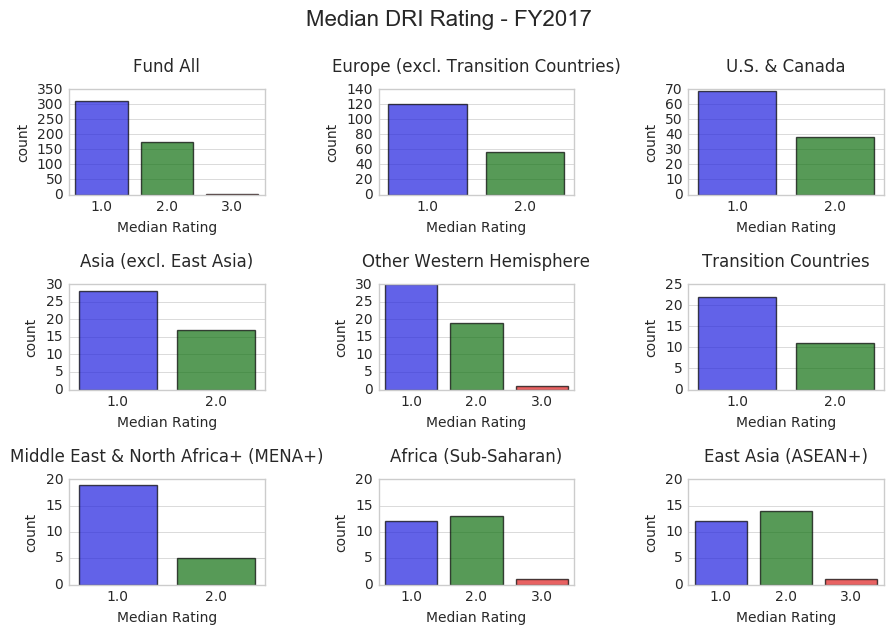

In [645]:
# Plot Median DRI rating for each region
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[empinfo_dri.FY == 2017].dropna(), alpha = 0.7)
plt.title('Fund All', y = 1.1)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 2)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Europe (excl. Transition Countries)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7)
plt.title('Europe (excl. Transition Countries)', y = 1.1)
plt.ylim(0,140)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 3)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'U.S. & Canada') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7)

plt.title('U.S. & Canada', y = 1.1)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 9)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'East Asia (ASEAN+)') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7)
plt.title('East Asia (ASEAN+)', y = 1.1)
plt.ylim(0,20)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 5)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.loc[(empinfo_dri['Diversity Region'] == 
                            'Other Western Hemisphere') & (empinfo_dri['FY'] == 2017)].dropna(), alpha = 0.7)
plt.title('Other Western Hemisphere', y = 1.1)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 6)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.dropna().loc[(empinfo_dri['Diversity Region'] == 
                            'Transition Countries') & (empinfo_dri['FY'] == 2017)], alpha = 0.7)

plt.title('Transition Countries', y = 1.1)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 7)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.dropna().loc[(empinfo_dri['Diversity Region'] == 
                            'Middle East & North Africa+ (MENA+)') & (empinfo_dri['FY'] == 2017)], alpha = 0.7)
plt.title('Middle East & North Africa+ (MENA+)', y = 1.1)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 8)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.dropna().loc[(empinfo_dri['Diversity Region'] == 
                            'Africa (Sub-Saharan)') & (empinfo_dri['FY'] == 2017)], alpha = 0.7)
plt.title('Africa (Sub-Saharan)', y = 1.1)
plt.ylim(0,20)
plt.xlabel('Median Rating')

plt.subplot(3, 3, 4)
sns.countplot(x = 'Median Rating (grouped)', data = empinfo_dri.dropna().loc[(empinfo_dri['Diversity Region'] == 
                            'Asia (excl. East Asia)') & (empinfo_dri['FY'] == 2017)], alpha = 0.7)

plt.title('Asia (excl. East Asia)', y = 1.1)
plt.xlabel('Median Rating')

plt.suptitle('Median DRI Rating - FY2017', y = 1.05, fontsize = 16)
fig.set_size_inches(w = 9, h = 6)
fig.tight_layout()
plt.show()

In [619]:
empinfo_dri.to_excel('test9.xlsx')

In [123]:
# Create a df which has only people with all 3 ratings from FY15 to 17
empinfo17_nonan = empinfo_17.dropna(subset = ['2015 Rating', '2016 Rating', '2017 Rating'], axis = 0, thresh = 3)

In [134]:
empinfo17_nonan.pivot_table(index = 'O/S past 3 yrs', columns = 'Gender', aggfunc = 'count', 
                            values = 'Emplid', margins = True)

Gender,F,M,All
O/S past 3 yrs,,,
0,333.0,384.0,717.0
1,692.0,832.0,1524.0
All,1025.0,1216.0,2241.0


In [155]:
# People who have ratings in 2017
empinfo_17_elig = empinfo_17.loc[empinfo_17['2017 Rating'].notnull()]
empinfo_17_elig.pivot_table(index = 'O/S past 3 yrs', columns = 'Gender', aggfunc = 'count', values = 'Emplid', margins = True)

Gender,F,M,All
O/S past 3 yrs,,,
0,497.0,553.0,1050.0
1,730.0,889.0,1619.0
All,1227.0,1442.0,2669.0


In [168]:
print("Number of NA ratings in FY17: ", len(empinfo_17[empinfo_17['2017 Rating'].isnull()]))
print("Number of people with ratings in FY17: ", len(empinfo_17[empinfo_17['2017 Rating'].notnull()]))
print("Number of people with all 3 ratings from FY15 to FY17: ", len(empinfo17_nonan))

Number of NA ratings in FY17:  1168
Number of people with ratings in FY17:  2669
Number of people with all 3 ratings from FY15 to FY17:  2241


In [163]:
# Share of ratings for 2017 APR
pivot1 = empinfo_17_elig.groupby('2017 Rating')['Emplid'].count()
pivot1 = pivot1.groupby(level = 0).apply(lambda x: x*100/len(empinfo_17_elig))
pivot1

2017 Rating
E    66.017235
N     0.149869
O    14.012739
R     5.207943
S    14.612214
Name: Emplid, dtype: float64

In [164]:
pivot2 = empinfo17_nonan.groupby('2017 Rating')['Emplid'].count()
pivot2 = pivot2.groupby(level = 0).apply(lambda x: x*100/len(empinfo17_nonan))
pivot2

2017 Rating
E    69.254797
N     0.089246
O    14.814815
R     0.089246
S    15.751896
Name: Emplid, dtype: float64

In [166]:
pivot3 = empinfo17_nonan.groupby('2016 Rating')['Emplid'].count()
pivot3 = pivot3.groupby(level = 0).apply(lambda x: x*100/len(empinfo17_nonan))
pivot3

2016 Rating
E    68.317715
O    15.707274
S    15.975011
Name: Emplid, dtype: float64

In [167]:
pivot4 = empinfo17_nonan.groupby('2015 Rating')['Emplid'].count()
pivot4 = pivot4.groupby(level = 0).apply(lambda x: x*100/len(empinfo17_nonan))
pivot4

2015 Rating
E    66.711290
N     2.498884
O    14.993307
S    15.796519
Name: Emplid, dtype: float64

In [172]:

# Count actual number of 'O' and 'S' past 3 yrs
empinfo17_nonan['Number of O/S past 3 yrs'] = np.sum([empinfo17_nonan['2017 Rating (num)'],empinfo17_nonan['2016 Rating (num)'],
           empinfo17_nonan['2015 Rating (num)']])


C:\Users\tle\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [173]:
empinfo17_nonan['Number of O/S past 3 yrs'].value_counts()

2085    2241
Name: Number of O/S past 3 yrs, dtype: int64

In [69]:
empinfo_dri.to_excel('test.xlsx')

In [154]:
empinfo_17_elig.to_excel('test4.xlsx')

In [174]:
empinfo17_nonan.head()

,FY,Emplid,Name,Gender,Nationality,Dept ID,Job Title,Incumbent Type,Grade,Employment Type,...,Total Fund Yrs of Service,Yrs of service,Diversity Region,URR,2017 Rating,2017 Rating (num),2016 Rating (num),2015 Rating (num),O/S past 3 yrs,Number of O/S past 3 yrs
2,2017,709819,"Abajyan,Gohar",F,Armenia,MCD,Research Officer,Specialized Career Stream,A09,S,...,16.23,14.06,Transition Countries,N,O,1,0,0,1,2085
3,2017,718101,"Abbas,Syed Mohammad Ali",M,Pakistan,SPR,Deputy Division Chief (SPR),Fungible Macroeconomist,A15,S,...,10.58,10.58,Middle East & North Africa+ (MENA+),Y,O,1,0,0,1,2085
5,2017,720841,"Abdallah,Chadi",M,Lebanon,FAD,Economist (FAD),Fungible Macroeconomist,A12,S,...,4.89,4.65,Middle East & North Africa+ (MENA+),Y,O,1,0,0,1,2085
7,2017,723098,"Abdelkader,Khaled Ibrah",M,Egypt,ICD,Senior Economist (ICD),Fungible Macroeconomist,A14,S,...,7.26,5.26,Middle East & North Africa+ (MENA+),Y,S,1,0,0,1,2085
9,2017,714658,"Abdih,Yasser",M,Lebanon,WHD,Senior Economist (Area),Fungible Macroeconomist,A14,S,...,12.57,12.57,Middle East & North Africa+ (MENA+),Y,E,0,0,1,1,2085


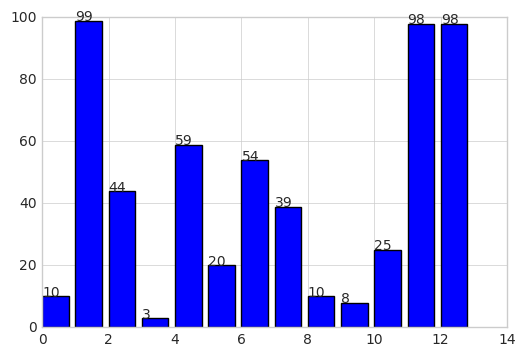

In [378]:
import random

x = range(13)
y = [random.randrange(100) for _ in range(13)]
plt.bar(x, y)
for a,b in zip(x, y):
    plt.text(a, b, str(b))
plt.show()
